In [6]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk  #https://github.com/cjhutto/vaderSentiment
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.feature_extraction import _stop_words
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk import FreqDist
import string
from wordcloud import WordCloud
lemmatizer = WordNetLemmatizer()
Stop_Words= _stop_words.ENGLISH_STOP_WORDS
nltk.download('omw-1.4')


import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import spacy
from time import time
%matplotlib inline

# Tools for processing data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, make_scorer, adjusted_rand_score, silhouette_score, homogeneity_score, normalized_mutual_info_score
# Classifiers, supervised and unsupervised
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
data=pd.read_csv('Top30.csv',index_col=0) # Read top30 media outlet articles

In [3]:
def sentiment(text):
    sia = SentimentIntensityAnalyzer()
    return(sia.polarity_scores(text))

In [4]:
def text_processing(text,lemmatizing=True,stop=True):
    # remove punctuation 
    text = "".join([c for c in text 
                    if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # remove stopwords
    if stop:
        text = " ".join([w for w in text.split() 
                         if w not in Stop_Words])
    if lemmatizing:
        # stemming / lematizing (optional)
        text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text

In [10]:
data['clean']=data['content'].apply(text_processing) # Apply text processing
data['sentiment']=data['clean'].apply(sentiment) # Extract sentiment indicators
data = data.join(data['sentiment'].apply(pd.Series)) # Distribuite indicators in columns
data['lenght']=data['content'].str.len() # Calculate lenght article

In [56]:
data=pd.read_csv('Articles_Sentiment_top30.csv')

In [57]:
data=data[data['author']!='Breitbart News'] # Remove Breitbart News as it isn't a proper author

In [58]:
# Make a DataFrame with articles by our chosen authors. Include author names and article titles.
# Make a list of the 30 chosen author names
names = data.author.value_counts()[data.author.value_counts()>100][-30:].index.tolist()
# DataFrame for articles of all chosen authors
authors_data = pd.DataFrame()
for name in names:
    # Select each author's data
    articles = data[data.author==name][:100]
    # Append it to the DataFrame
    authors_data = authors_data.append(articles)
authors_data = authors_data.reset_index().drop('index',1)

In [59]:
authors_data['new_id'] = pd.factorize(authors_data['author'])[0] # Transform author's name into unique number to compare with cluster later on
authors_df=authors_data.drop_duplicates(subset='new_id')[['author','new_id']]  # Unique author df

In [60]:
# Establish outcome and predictors
y = authors_data['new_id'] # Each author ID 
X = authors_data[['pos','neg','neu']] # Sentiment indicators
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.24,
                                                    random_state=0,
                                                    stratify=y)

In [61]:
metrics = ['Algorithm','n_train','Features','ARI','Homogeneity',
           'Silhouette','Mutual_Info','Cross_Val','Train_Accuracy',
           'Test_Accuracy']
performance = pd.DataFrame(columns=metrics)

In [62]:
# Function to quickly evaluate clustering solutions
def evaluate_clust(clust,params,features,i):
    t0 = time()
    print('\n','-'*40,'\n',clust.__class__.__name__,'\n','-'*40)
    
    # Find best parameters based on scoring of choice
    score = make_scorer(normalized_mutual_info_score)
    search = GridSearchCV(clust,params,scoring=score,cv=3).fit(X,y)
    print("Best parameters:",search.best_params_)
    y_pred = search.best_estimator_.fit_predict(X)

    ari = adjusted_rand_score(y, y_pred)
    performance.loc[i,'ARI'] = ari 
    print("Adjusted Rand-Index: %.3f" % ari)
    
    hom = homogeneity_score(y,y_pred)
    performance.loc[i,'Homogeneity'] = hom
    print("Homogeneity Score: %.3f" % hom)
    
    sil = silhouette_score(X,y_pred)
    performance.loc[i,'Silhouette'] = sil
    print("Silhouette Score: %.3f" % sil)
    
    nmi = normalized_mutual_info_score(y,y_pred)
    performance.loc[i,'Mutual_Info'] = nmi
    print("Normed Mutual-Info Score: %.3f" % nmi)
    
    performance.loc[i,'n_train'] = len(X)
    performance.loc[i,'Features'] = features
    performance.loc[i,'Algorithm'] = clust.__class__.__name__
    
    # Print contingency matrix
    crosstab = pd.crosstab(y, y_pred)
    plt.figure(figsize=(8,5))
    sns.heatmap(crosstab, annot=True,fmt='d', cmap=plt.cm.copper)
    plt.show()
    print(time()-t0,"seconds.")

In [63]:
# Function to evaluate acccuracy for each author and each method
def authors_accuracy(Spectralclustering=False,Affinitypropagation=False,Meanshift=False,Kmeans=False,n_clusters=None,init=None,n_init=None,X_train=None,X_test=None,y_test=None,damping= None, max_iter= None,authors_df=None):
    if Kmeans:
        clust = KMeans(n_clusters= 29,init='k-means++',n_init=20).fit(X_train)
    if Meanshift:
        clust = MeanShift().fit(X_train)
    if Affinitypropagation:
        clust = AffinityPropagation(damping= damping, max_iter= max_iter).fit(X_train)
    if Spectralclustering:
        predict_list = SpectralClustering().fit_predict(X_train)
    y_test2=y_test.copy()
    y_test2['prediction']=0
    y_test2=y_test2.reset_index()
    if not Spectralclustering:
        predict_list=clust.predict(X_test)
    for number,predic in enumerate(predict_list):
        y_test2.loc[number,'prediction']=int(predic)
    y_test2.dropna(subset='prediction',inplace=True)
    y_test2['prediction']=y_test2['prediction'].astype(int)
    y_test2['match']=np.where(y_test2['prediction']==y_test2['new_id'],1,0)
    y_test2=y_test2[['new_id','match']]
    accuracy_by_author=y_test2.groupby('new_id').sum().reset_index()
    authors_df=authors_df.merge(accuracy_by_author,on='new_id')
    if Kmeans:
        authors_df['accuracy_kmeans']=authors_df['match']/24
    if Meanshift:
        authors_df['accuracy_MeanShift']=authors_df['match']/24
    if Affinitypropagation:
        authors_df['accuracy_AffinityPropagation']=authors_df['match']/24
    if Spectralclustering:
        authors_df['accuracy_SpectralClustering']=authors_df['match']/24
    del authors_df['match']
    return authors_df


 ---------------------------------------- 
 KMeans 
 ----------------------------------------
Best parameters: {'init': 'k-means++', 'n_clusters': 29, 'n_init': 20}
Adjusted Rand-Index: 0.013
Homogeneity Score: 0.099
Silhouette Score: 0.331
Normed Mutual-Info Score: 0.101


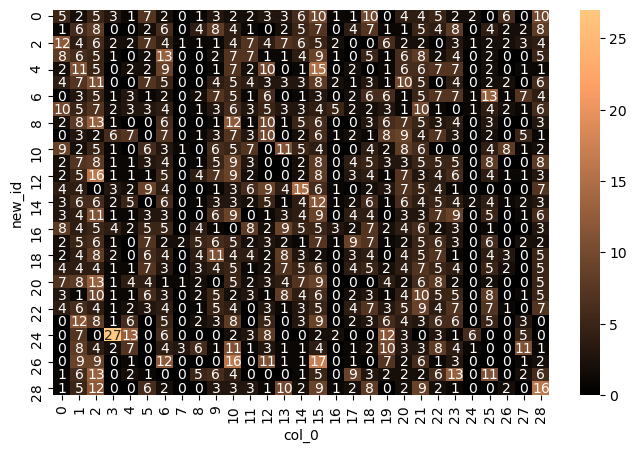

53.84597873687744 seconds.


In [64]:
clust=KMeans()
params={
    'n_clusters': np.arange(9,34,5),
    'init': ['k-means++','random'],
    'n_init':[10,20],
    #'precompute_distances':[True,False]
}
evaluate_clust(clust,params,features='Sentiment',i=0)

In [65]:
authors_df=authors_accuracy(Kmeans=True,n_clusters= 29,init='k-means++',n_init=20,X_train=X_train,X_test=X_test,y_test=y_test,authors_df=authors_df)


 ---------------------------------------- 
 MeanShift 
 ----------------------------------------
Best parameters: {}
Adjusted Rand-Index: 0.000
Homogeneity Score: 0.004
Silhouette Score: 0.476
Normed Mutual-Info Score: 0.007


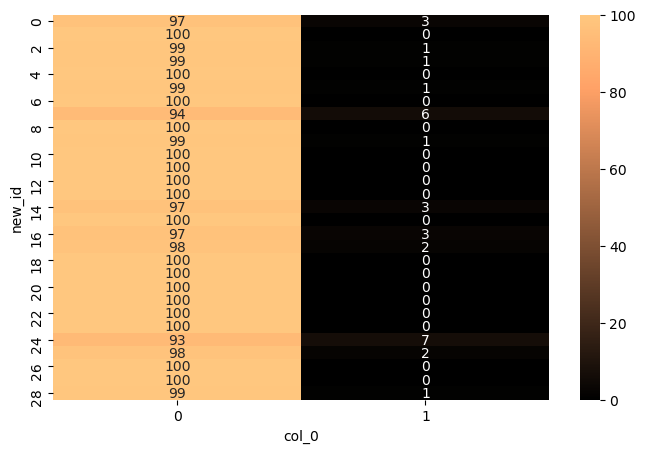

63.89430332183838 seconds.


In [66]:
#Declare and fit the model
clust = MeanShift()
params={}
evaluate_clust(clust,params,features='Sentiment',i=1)

In [67]:
authors_df=authors_accuracy(Meanshift=True,X_train=X_train,X_test=X_test,y_test=y_test,authors_df=authors_df)


 ---------------------------------------- 
 AffinityPropagation 
 ----------------------------------------
Best parameters: {'damping': 0.5, 'max_iter': 200}
Adjusted Rand-Index: 0.008
Homogeneity Score: 0.235
Silhouette Score: 0.212
Normed Mutual-Info Score: 0.200


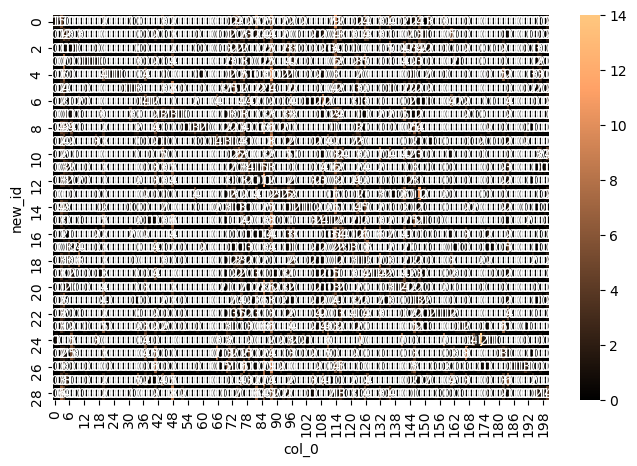

421.24897170066833 seconds.


In [68]:
#Declare and fit the model.
clust = AffinityPropagation()
params = {
    'damping':[.5,.7,.9],
    'max_iter':[200,500]
}
evaluate_clust(clust,params,features='Sentiment',i=2)

In [69]:
authors_df=authors_accuracy(Affinitypropagation=True,damping= 0.5, max_iter= 200,X_train=X_train,X_test=X_test,y_test=y_test,authors_df=authors_df)

Adjusted Rand-Index: 0.010
Homogeneity Score: 0.046
Silhouette Score: -0.005
Normed Mutual-Info Score: 0.063


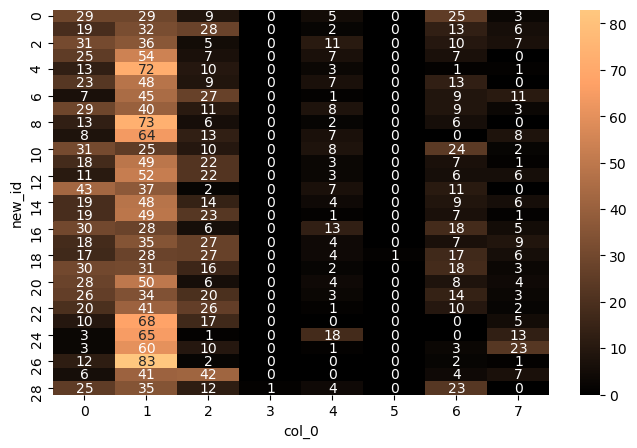

57.16987061500549 seconds.


In [70]:
clust= SpectralClustering()

params = {
    'n_clusters':np.arange(9,34,5),
    'n_init':[15,25],
    'assign_labels':['kmeans','discretize']
}

features='Sentiment'

i=3

t0=time()

y_pred = clust.fit_predict(X)

ari = adjusted_rand_score(y, y_pred)
performance.loc[i,'ARI'] = ari 
print("Adjusted Rand-Index: %.3f" % ari)

hom = homogeneity_score(y,y_pred)
performance.loc[i,'Homogeneity'] = hom
print("Homogeneity Score: %.3f" % hom)

sil = silhouette_score(X,y_pred)
performance.loc[i,'Silhouette'] = sil
print("Silhouette Score: %.3f" % sil)

nmi = normalized_mutual_info_score(y,y_pred)
performance.loc[i,'Mutual_Info'] = nmi
print("Normed Mutual-Info Score: %.3f" % nmi)

performance.loc[i,'n_train'] = len(X)
performance.loc[i,'Features'] = features
performance.loc[i,'Algorithm'] = clust.__class__.__name__

# Print contingency matrix
crosstab = pd.crosstab(y, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(crosstab, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()
print(time()-t0,"seconds.")

In [71]:
authors_df=authors_accuracy(Spectralclustering=True,X_train=X_train,X_test=X_test,y_test=y_test,authors_df=authors_df)

In [72]:
authors_df

,author,new_id,accuracy_kmeans,accuracy_MeanShift,accuracy_AffinityPropagation,accuracy_SpectralClustering
0,Pam Key,0,0.000000,1.0,0.000000,0.041667
1,Associated Press,1,0.125000,0.0,0.000000,0.458333
2,Charlie Spiering,2,0.041667,0.0,0.000000,0.041667
3,Jerome Hudson,3,0.000000,0.0,0.000000,0.000000
4,John Hayward,4,0.000000,0.0,0.000000,0.166667
5,Daniel Nussbaum,5,0.041667,0.0,0.000000,0.000000
6,AWR Hawkins,6,0.041667,0.0,0.000000,0.000000
7,Ian Hanchett,7,0.000000,0.0,0.000000,0.208333
8,Joel B. Pollak,8,0.083333,0.0,0.000000,0.000000
9,Post Editorial Board,9,0.000000,0.0,0.000000,0.000000


In [73]:
performance.iloc[:,:7]

,Algorithm,n_train,Features,ARI,Homogeneity,Silhouette,Mutual_Info
0,KMeans,2900,Sentiment,0.012899,0.098976,0.330857,0.101117
1,MeanShift,2900,Sentiment,0.000031,0.003629,0.475647,0.007132
2,AffinityPropagation,2900,Sentiment,0.007895,0.234644,0.211625,0.200106
3,SpectralClustering,2900,Sentiment,0.009983,0.045608,-0.004877,0.063442
